In [1]:
# for compatibility with CLRS, we advise using Python 3.9 or later
# install required packages (only need to run once)
#!pip install -e .

import matplotlib.pyplot as plt
import torch
from torch.nn import functional as F
from ltfs.common.logic import less_than, if_else
from ltfs.common.proto import BaseMLP

def compute_hessian(param, closure_loss):
    hessian_entries = []
    param_with_grad = [p for p in param if p.requires_grad]
    grads = torch.autograd.grad(closure_loss, param_with_grad, create_graph=True)
    for grad in grads:
        for grad_i in grad.view(-1):
            hessian_row_i = torch.autograd.grad(grad_i, param_with_grad, retain_graph=True)
            hessian_row_i = [item.item() for sublist in hessian_row_i for item in sublist.view(-1)]
            hessian_entries.append(hessian_row_i)
    return torch.tensor(hessian_entries)

d = 12 # input dimension
# define some placeholder structure because the layer definition requires it (the data will be random though)
index = {"X": slice(0, 1), "Y": slice(1, 2), "Z": slice(2, 3), "W": slice(3, 4), "B_global": slice(4, 5), "B_local": slice(6, 7), "S": slice(6, 12)}
threshold = 1e-14 # threshold for the hessian singular values
X = torch.randn(20000, d)

### Baseline - Randomly initialized MLP

In [2]:
layer = BaseMLP(d, False)
layer.reset_parameters()

for param in layer.parameters():
    param.requires_grad = True

with torch.no_grad():
    y = layer(X)
y_hat = layer(X)
loss = F.mse_loss(y_hat, y)

H = compute_hessian(layer.parameters(), loss)
S = torch.linalg.svd(H)[1]
cond_number = S.max()/S[S > threshold].min()
print("Effective condition number:", cond_number.round().item())

Effective condition number: 9233762595.0


### Case 1 - Less-than function

1.00e-07: 2.34e+17
5.00e-07: 5.84e+17
1.00e-06: 4.93e+17
5.00e-06: 1.68e+18
1.00e-05: 1.23e+18
5.00e-05: 1.30e+18
1.00e-04: 1.22e+19
5.00e-04: 9.53e+17
1.00e-03: 2.17e+18
5.00e-03: 3.72e+17
1.00e-02: 3.51e+17
5.00e-02: 1.58e+16
1.00e-01: 5.07e+15
5.00e-01: 2.96e+03
1.00e+00: 2.91e+03


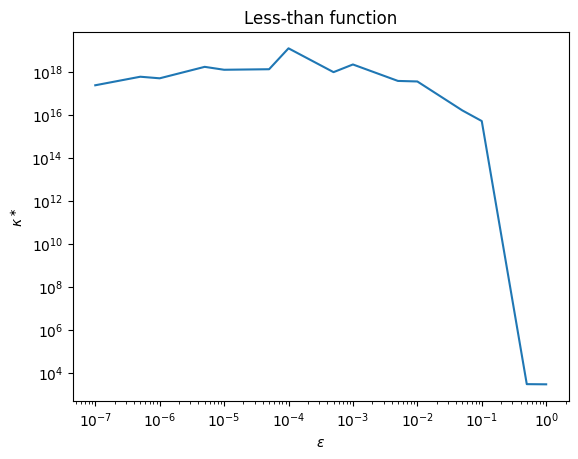

In [3]:
tols = [1e-7, 5e-7, 1e-6, 5e-6, 1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 5e-2, 1e-1, 5e-1, 1]
tol_vals = []
for tol in tols:
    layer = less_than(d, index, "X", "Y", "Z", tol=tol)[0]
    for param in layer.parameters():
        param.requires_grad = True

    with torch.no_grad():
        y = layer(X)
    y_hat = layer(X)
    loss = F.mse_loss(y_hat, y)

    H = compute_hessian(layer.parameters(), loss)
    S = torch.linalg.svd(H)[1]
    tol_vals.append(S.max()/S[S > threshold].min())

for omega, val in zip(tols, tol_vals):
    print(f"{omega:.2e}: {val:.2e}")

plt.plot(tols, tol_vals)
plt.xlabel(r"$\varepsilon$") # tolerance
plt.ylabel(r"$\kappa^\ast$") # effective condition number
plt.xscale("log")
plt.yscale("log")
plt.title("Less-than function");

### Case 2: If-else function

1.00e+00: 1.15e+05
5.00e+00: 5.48e+06
1.00e+01: 6.84e+07
5.00e+01: 1.56e+16
1.00e+02: 1.79e+16
5.00e+02: 9.01e+15
1.00e+03: 2.49e+18
5.00e+03: 8.02e+19
1.00e+04: 5.01e+20
5.00e+04: 6.80e+17
1.00e+05: 5.97e+18
5.00e+05: 1.93e+22
1.00e+06: 3.39e+22
5.00e+06: 1.02e+25
1.00e+07: 4.94e+21


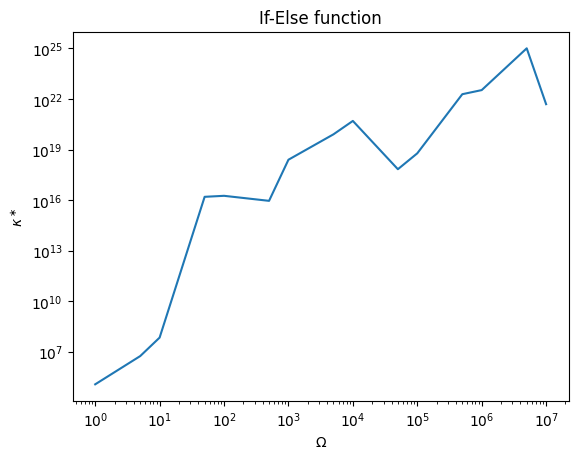

In [4]:
omegas = [1, 5, 1e1, 5e1, 1e2, 5e2, 1e3, 5e3, 1e4, 5e4, 1e5, 5e5, 1e6, 5e6, 1e7]
omega_vals = []
for omega in omegas:
    layer = if_else(d, index, ["X"], ["Y"], "Z", ["W"], ifINF=omega)[0]
    for param in layer.parameters():
        param.requires_grad = True

    with torch.no_grad():
        y = layer(X)
    y_hat = layer(X)
    loss = F.mse_loss(y_hat, y)

    H = compute_hessian(layer.parameters(), loss)
    S = torch.linalg.svd(H)[1]
    omega_vals.append(S.max()/S[S > threshold].min())

for omega, val in zip(omegas, omega_vals):
    print(f"{omega:.2e}: {val:.2e}")

plt.plot(omegas, omega_vals)
plt.xlabel(r"$\Omega$")
plt.ylabel(r"$\kappa^\ast$")
plt.xscale("log")
plt.yscale("log")
plt.title("If-Else function");